In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix


### Understanding the Dataset.

In [2]:
data=pd.read_csv('dataset_churn.csv')
data.head()

,Unnamed: 0,CustomerID,Age,Gender,Tenure,Service_Internet,Service_Phone,Service_TV,Contract,PaymentMethod,MonthlyCharges,TotalCharges,StreamingMovies,StreamingMusic,OnlineSecurity,TechSupport,Churn
0,0,08729464-bde6-43bc-8f63-a357096feab1,56.0,Male,13,DSL,Yes,No,One year,Mailed check,71.88,931.49,No,No,Yes,No,No
1,1,af95bc95-baf4-4318-a21d-70d2ea3148b7,69.0,Male,13,DSL,No,Yes,Two year,Mailed check,110.99,1448.46,Yes,Yes,No,No,No
2,2,1fe7eee6-2227-4400-9998-4d993f4a60fd,46.0,Male,60,Fiber optic,No,Yes,Month-to-month,Mailed check,116.74,6997.73,Yes,Yes,No,No,No
3,3,f736fe7b-1b44-4acd-84c2-21c4aef648be,32.0,Female,57,Fiber optic,Yes,Yes,Month-to-month,Bank transfer,78.16,4452.13,No,Yes,No,Yes,No
4,4,4b40d12d-7633-4309-96b8-aee675ea20ae,60.0,Male,52,Fiber optic,Yes,Yes,Two year,Electronic check,30.33,1569.73,Yes,No,Yes,Yes,No


In [3]:
data=data.drop(columns=['Unnamed: 0'])
data=data.drop(columns=['CustomerID'])

In [4]:
data.shape

(3749, 15)

In [5]:
data.dtypes

Age                 float64
Gender               object
Tenure                int64
Service_Internet     object
Service_Phone        object
Service_TV           object
Contract             object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
StreamingMovies      object
StreamingMusic       object
OnlineSecurity       object
TechSupport          object
Churn                object
dtype: object

In [6]:
numerical_feature=data.select_dtypes(include=['float64', 'int64'])

In [7]:
data.describe()

,Age,Tenure,MonthlyCharges,TotalCharges
count,3562.000000,3749.000000,3749.000000,3749.000000
mean,43.655531,36.264070,75.844318,2718.968266
std,14.914474,20.505528,73.062971,3211.879149
min,18.000000,1.000000,20.000000,13.190000
25%,31.000000,19.000000,44.570000,1076.240000
50%,44.000000,36.000000,69.590000,2132.260000
75%,56.000000,54.000000,95.540000,3619.710000
max,69.000000,71.000000,1179.300000,79951.800000


# Data Preprocessing.

In [8]:
# Checking for missing values
data.isnull().sum()

Age                 187
Gender                0
Tenure                0
Service_Internet    721
Service_Phone         0
Service_TV            0
Contract              0
PaymentMethod       187
MonthlyCharges        0
TotalCharges          0
StreamingMovies       0
StreamingMusic        0
OnlineSecurity        0
TechSupport           0
Churn                 0
dtype: int64

In [9]:
#Handaling the missing value of the age
data['Age'].fillna(data['Age'].median(), inplace=True)

#Handaling the missing value of the categorical
data['PaymentMethod'].fillna(data['PaymentMethod'].mode()[0], inplace=True)

data['Service_Internet'].fillna(data['Service_Internet'].mode()[0], inplace=True)


In [10]:
data.isnull().sum()

Age                 0
Gender              0
Tenure              0
Service_Internet    0
Service_Phone       0
Service_TV          0
Contract            0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
StreamingMovies     0
StreamingMusic      0
OnlineSecurity      0
TechSupport         0
Churn               0
dtype: int64

In [11]:
categorical_feature=data.select_dtypes(include=['object'])
for feature in categorical_feature.columns:
    data[feature]=LabelEncoder().fit_transform(data[feature])
data.head()

,Age,Gender,Tenure,Service_Internet,Service_Phone,Service_TV,Contract,PaymentMethod,MonthlyCharges,TotalCharges,StreamingMovies,StreamingMusic,OnlineSecurity,TechSupport,Churn
0,56.0,1,13,0,1,0,1,3,71.88,931.49,0,0,1,0,0
1,69.0,1,13,0,0,1,2,3,110.99,1448.46,1,1,0,0,0
2,46.0,1,60,1,0,1,0,3,116.74,6997.73,1,1,0,0,0
3,32.0,0,57,1,1,1,0,0,78.16,4452.13,0,1,0,1,0
4,60.0,1,52,1,1,1,2,2,30.33,1569.73,1,0,1,1,0


# Outliers **checking**

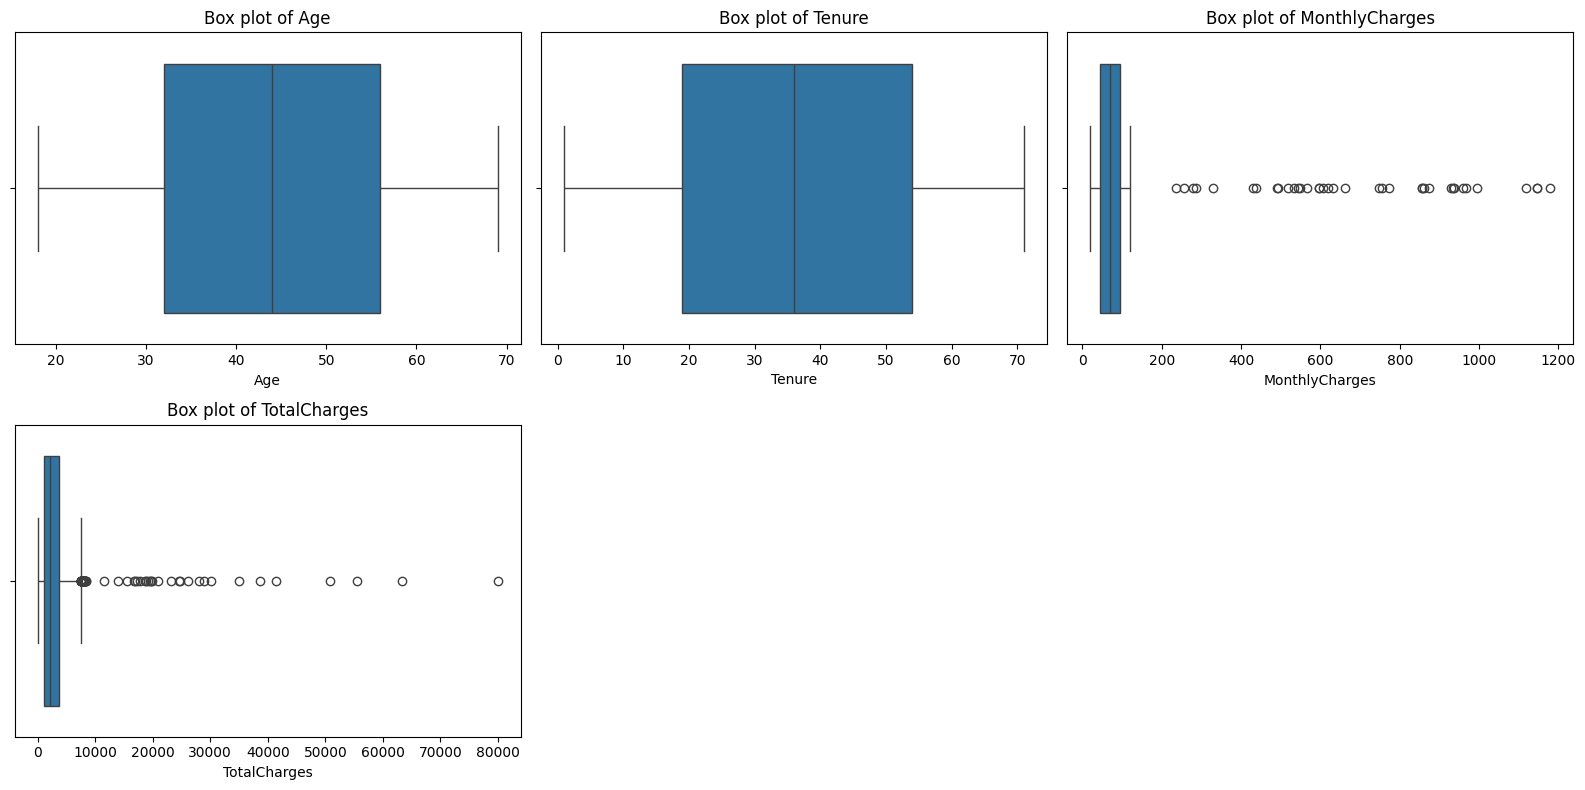

In [12]:

plt.figure(figsize=(16,8))
for i,features in enumerate (numerical_feature,1):
    plt.subplot(2,3,i)
    sns.boxplot(x=data[features])
    plt.title(f'Box plot of {features}')
plt.tight_layout()
plt.show()


In [13]:

def iqr_outliers(dataset,feature_name):

    Q1 = dataset[feature_name].quantile(0.25)
    Q3 = dataset[feature_name].quantile(0.75)

    IQR = Q3 - Q1

    lwr_bound = Q1 - 1.5 * IQR
    upp_bound = Q3 + 1.5 * IQR

    outliers_indices= dataset.index[np.logical_or(dataset[feature_name]<lwr_bound,
                                dataset[feature_name]>upp_bound)]
    return outliers_indices

outliers_detected={}
for feature in numerical_feature:
    outliers = iqr_outliers(data,feature)
    outliers_detected[feature] = outliers
    print(outliers)


Index([], dtype='int64')
Index([], dtype='int64')
Index([  34,  106,  217,  253,  379,  590,  639,  667,  733,  787,  791,  938,
        944, 1043, 1151, 1258, 1261, 1343, 1619, 1904, 1952, 1982, 2356, 2495,
       2497, 2509, 2590, 2601, 2736, 2851, 2977, 3085, 3137, 3210, 3246, 3459,
       3514],
      dtype='int64')
Index([  27,   38,   44,  132,  280,  311,  494,  526,  582,  620,  631,  646,
        691,  767,  871,  890,  896,  905,  934,  943, 1107, 1296, 1302, 1388,
       1390, 1472, 1499, 1545, 1550, 1602, 1637, 1682, 1731, 1776, 1827, 1927,
       2111, 2125, 2149, 2361, 2421, 2428, 2505, 2517, 2549, 2556, 2700, 2785,
       2803, 2825, 2841, 2851, 2958, 2989, 2996, 3036, 3103, 3122, 3200, 3258,
       3382, 3392, 3469, 3565, 3574, 3575, 3627, 3648, 3663, 3669, 3719, 3724,
       3733],
      dtype='int64')


In [14]:

for i in numerical_feature:
    data[i] = data[i].replace(data[i].iloc[outliers_detected[i]].values,data[i].median())

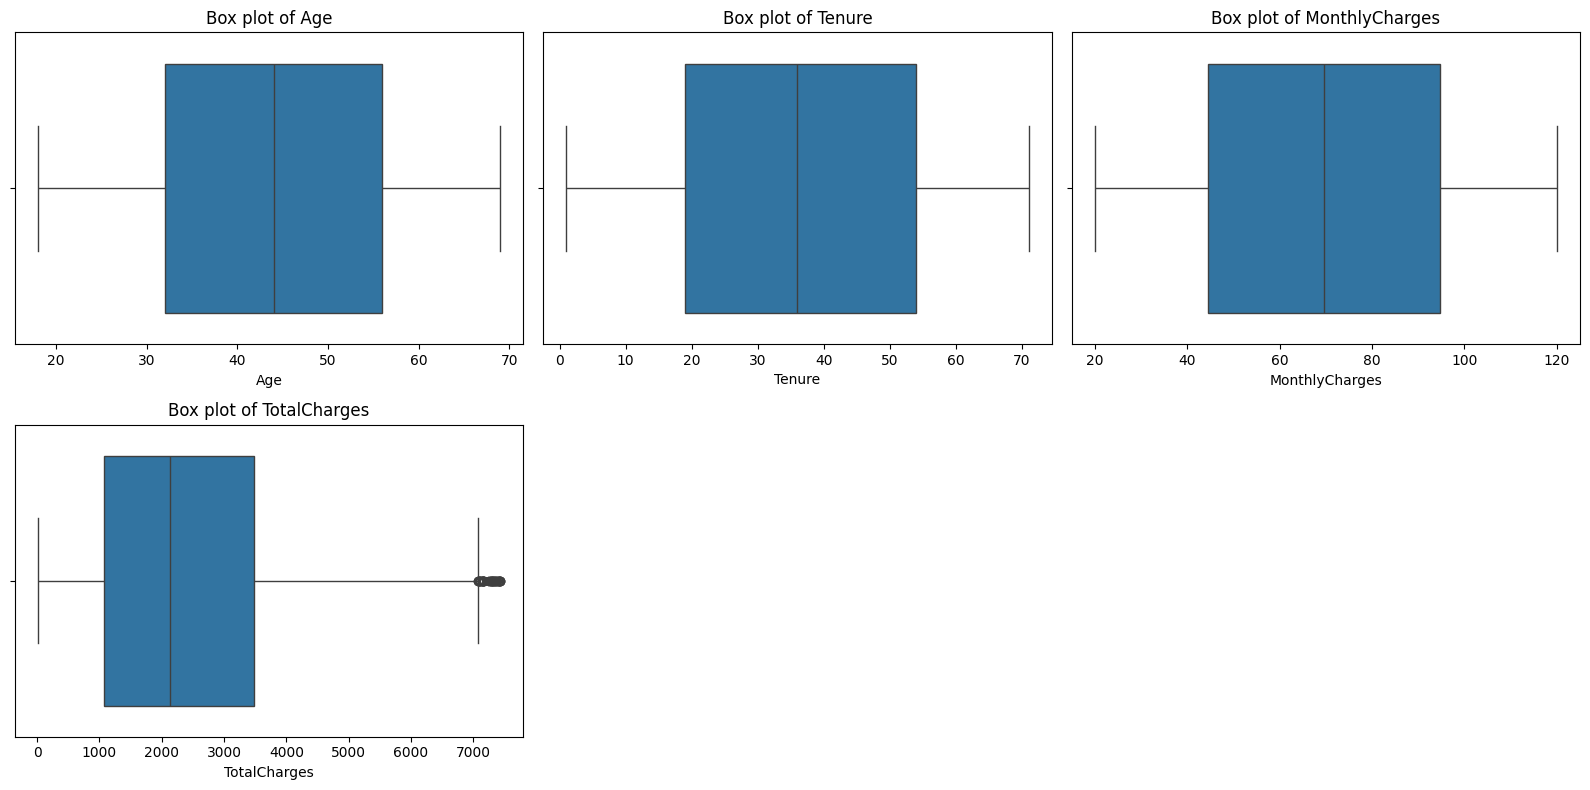

In [15]:
plt.figure(figsize=(16,8))
for i, feature in enumerate(numerical_feature,1):
    plt.subplot(2,3,i)
    sns.boxplot(x=data[feature])
    plt.title(f'Box plot of {feature}')
plt.tight_layout()
plt.show()

In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
data.to_csv('/content/drive/MyDrive/ML_project/clean_data.csv')

# EDA ( Exploratory Data Analysis )

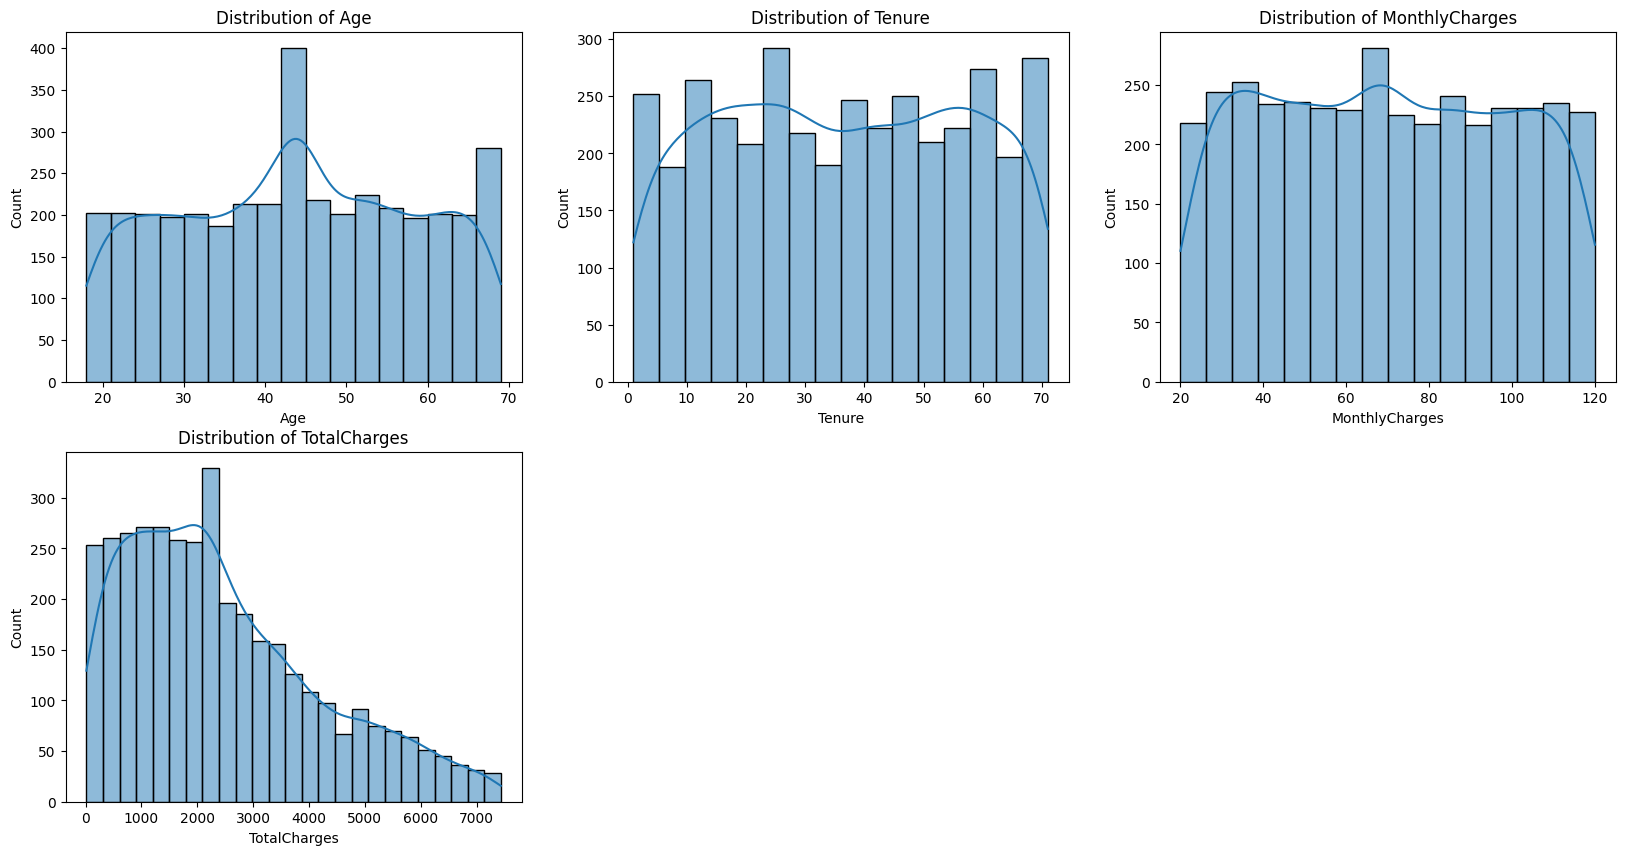

In [18]:

plt.figure(figsize=(20,10))
for i , col in enumerate(numerical_feature, 1):
    plt.subplot(2,3,i)
    sns.histplot(data[col],kde=True)
    plt.title(f'Distribution of {col}')
plt.show()

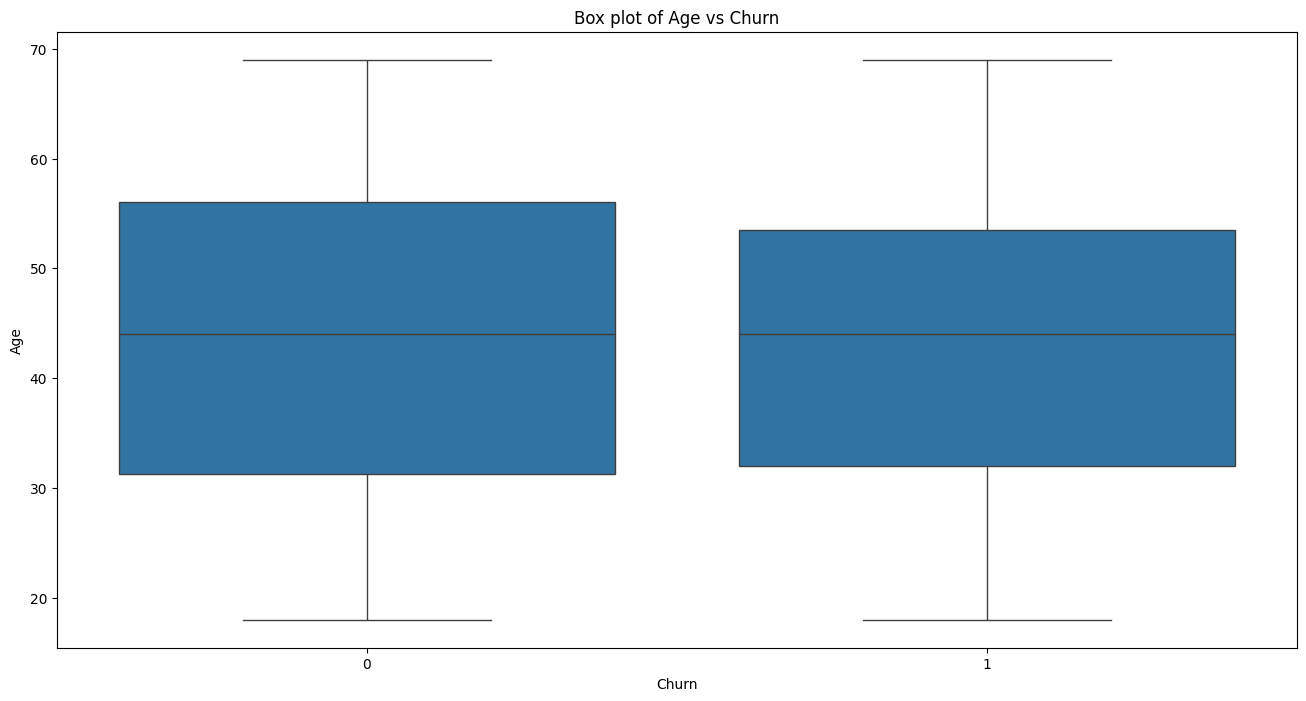

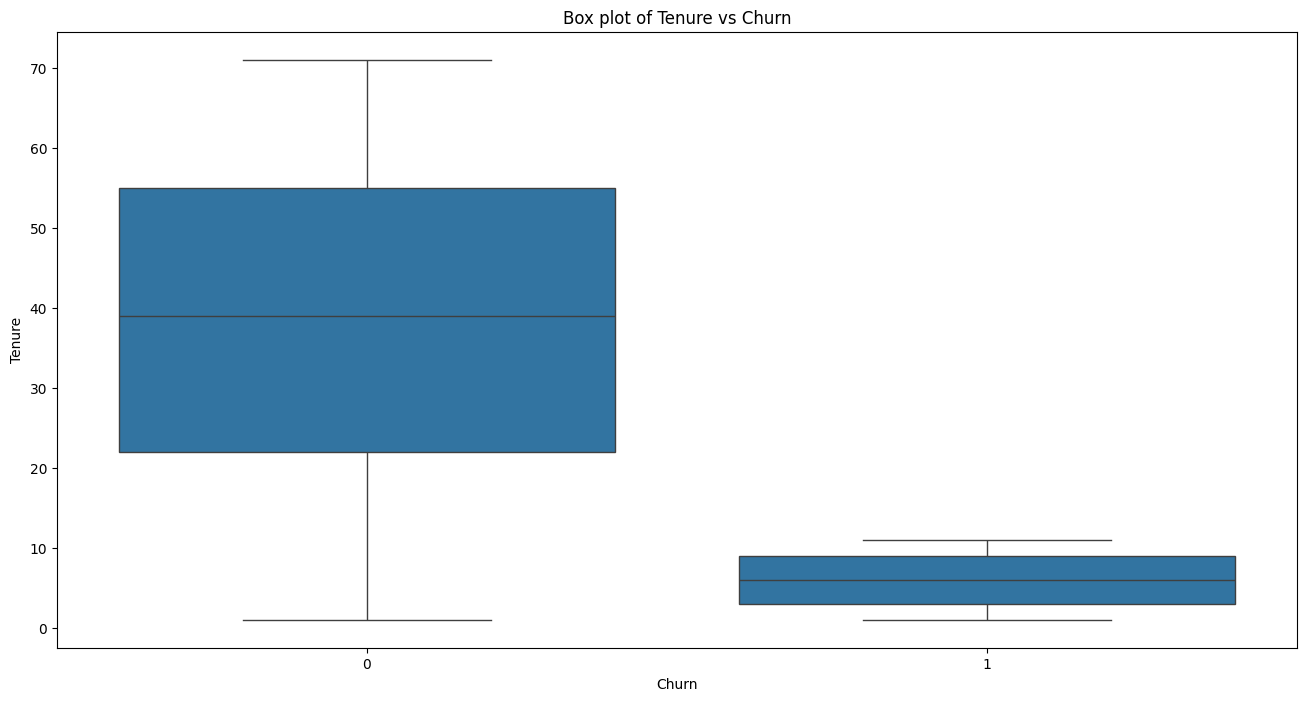

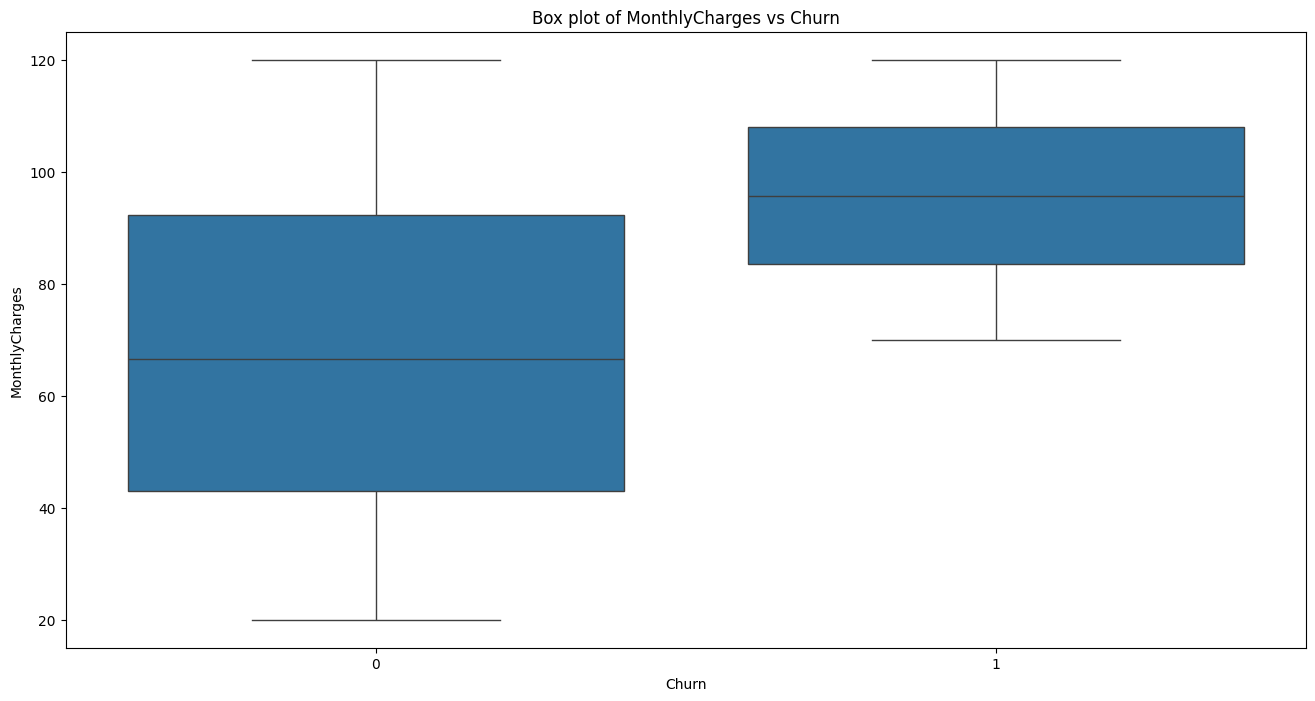

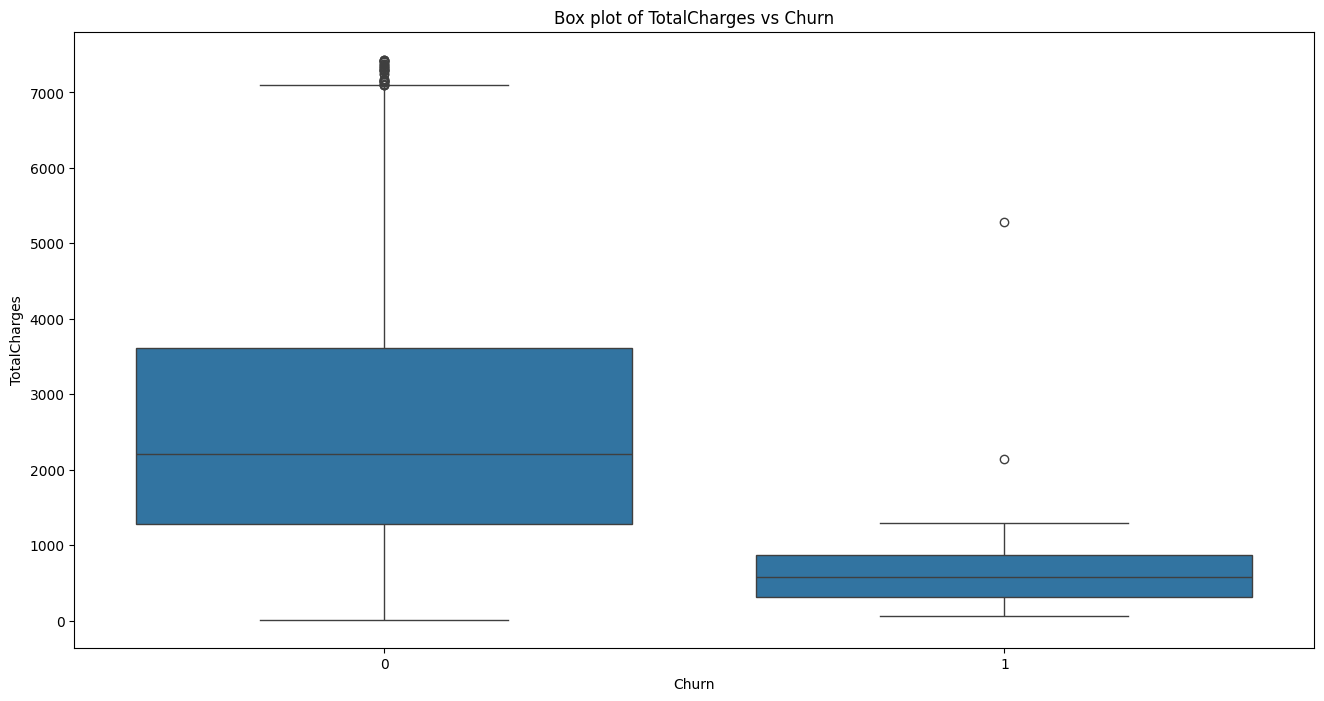

In [19]:
for feature in numerical_feature:
    plt.figure(figsize=(16,8))
    sns.boxplot(x='Churn', y=feature, data=data)
    plt.title(f'Box plot of {feature} vs Churn')
    plt.show()

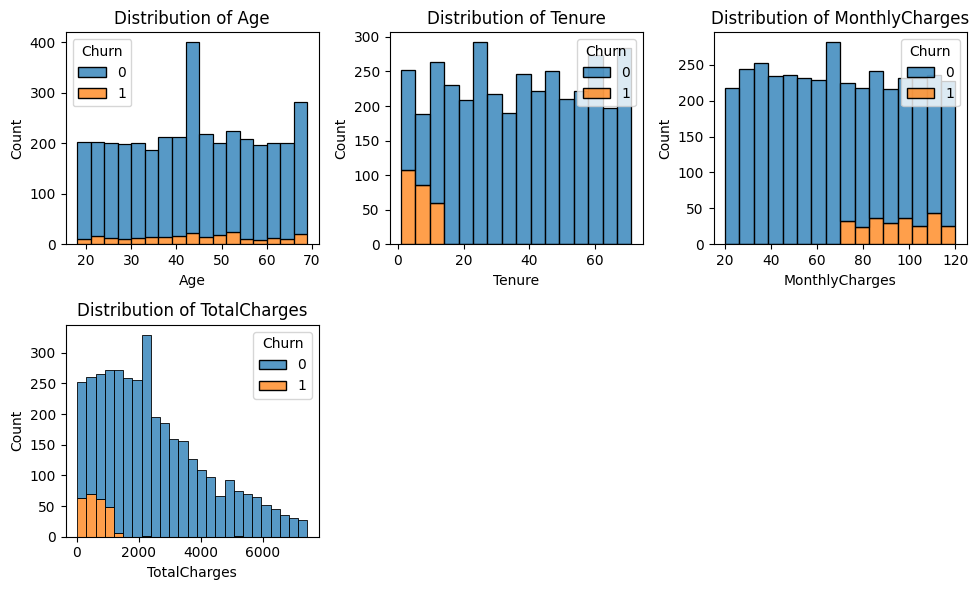

In [20]:
plt.figure(figsize=(10, 6))
for i,feature in enumerate(numerical_feature,1):
    plt.subplot(2,3,i)
    sns.histplot(data=data, x=feature, hue='Churn', multiple='stack')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

correlation Metrix

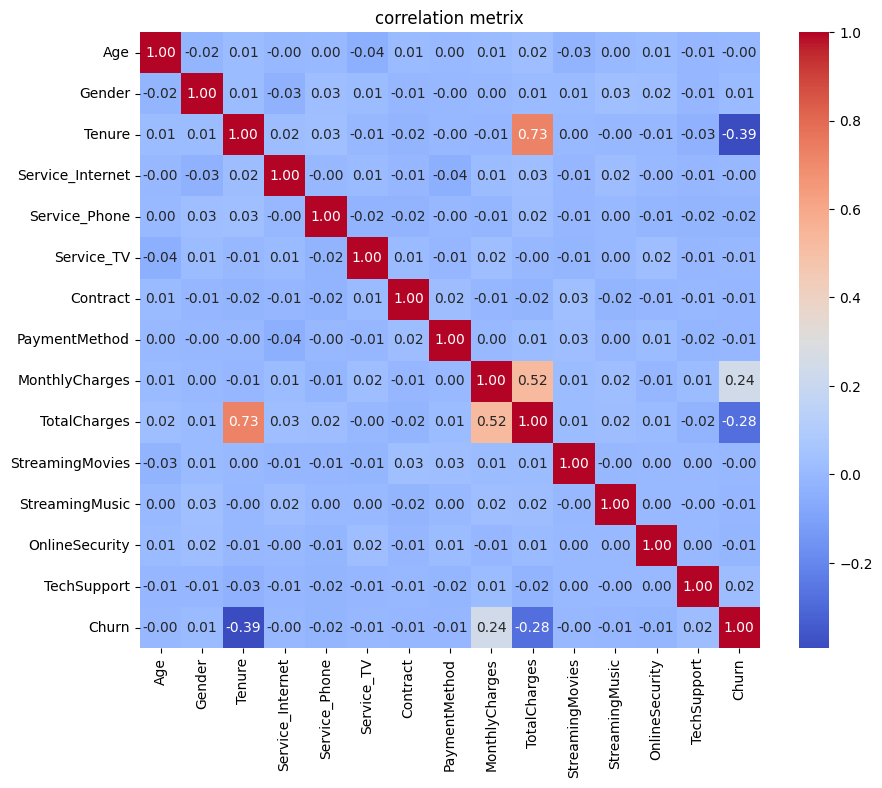

In [21]:

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('correlation metrix')
plt.show()

Categorical features

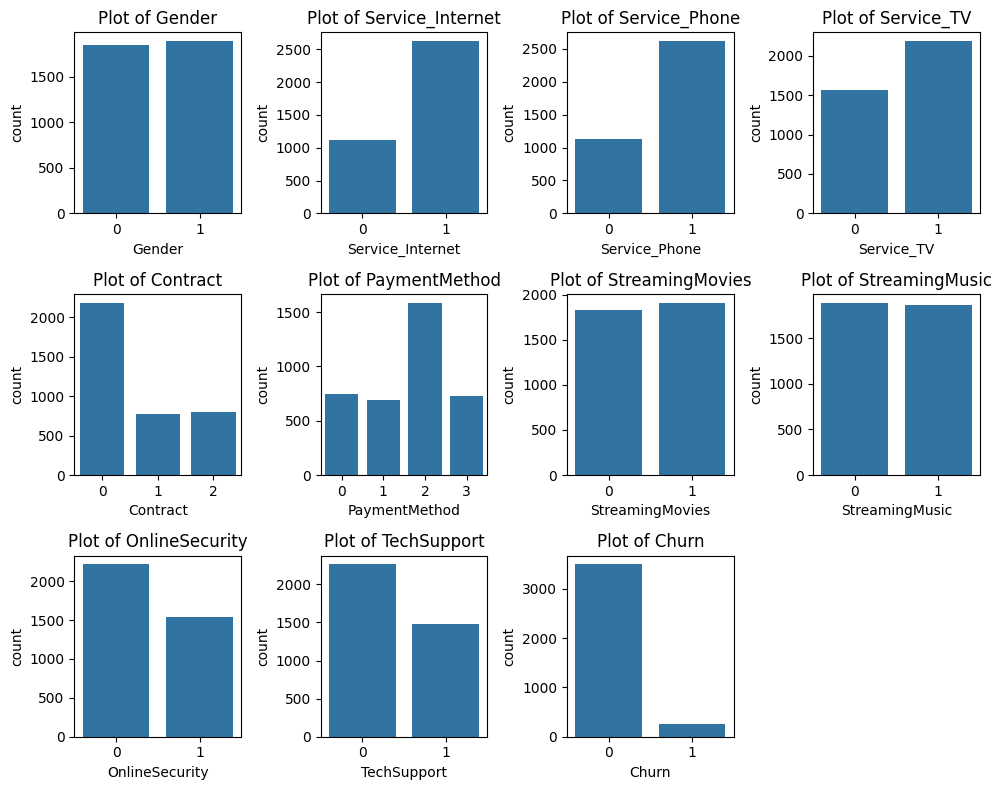

In [22]:
#age male:1, female:0
plt.figure(figsize=(10,8))
for i ,feature in enumerate (categorical_feature,1):
    plt.subplot(3,4,i)
    sns.countplot(x=data[feature])
    plt.title(f'Plot of {feature}')
plt.tight_layout()
plt.show()


# Feature engineering

In [23]:
# Function to engineer new features
def feature_engineering(data):

    data['MonthlyCharges_per_Tenure'] = data['MonthlyCharges'] / (data['Tenure'] + 1)

    data['TotalCharges_per_Tenure'] = data['TotalCharges'] / (data['Tenure'] + 1)

    # Total number of services
    data['TotalServices'] = (data['Service_Internet'] + data['Service_Phone'] + data['Service_TV'] +
                             data['StreamingMovies'] + data['StreamingMusic'] + data['OnlineSecurity'] + data['TechSupport'])

    # Flag for high probability of Churn status

    data['churn_high_probability'] = (data['Tenure'] <= 20).astype(int)

    return data


data = feature_engineering(data)

data.head()


,Age,Gender,Tenure,Service_Internet,Service_Phone,Service_TV,Contract,PaymentMethod,MonthlyCharges,TotalCharges,StreamingMovies,StreamingMusic,OnlineSecurity,TechSupport,Churn,MonthlyCharges_per_Tenure,TotalCharges_per_Tenure,TotalServices,churn_high_probability
0,56.0,1,13,0,1,0,1,3,71.88,931.49,0,0,1,0,0,5.134286,66.535000,2,1
1,69.0,1,13,0,0,1,2,3,110.99,1448.46,1,1,0,0,0,7.927857,103.461429,3,1
2,46.0,1,60,1,0,1,0,3,116.74,6997.73,1,1,0,0,0,1.913770,114.716885,4,0
3,32.0,0,57,1,1,1,0,0,78.16,4452.13,0,1,0,1,0,1.347586,76.760862,5,0
4,60.0,1,52,1,1,1,2,2,30.33,1569.73,1,0,1,1,0,0.572264,29.617547,6,0


# Split of the Data

In [24]:
X = data.drop('Churn', axis=1)
y = data['Churn']

X.head()

,Age,Gender,Tenure,Service_Internet,Service_Phone,Service_TV,Contract,PaymentMethod,MonthlyCharges,TotalCharges,StreamingMovies,StreamingMusic,OnlineSecurity,TechSupport,MonthlyCharges_per_Tenure,TotalCharges_per_Tenure,TotalServices,churn_high_probability
0,56.0,1,13,0,1,0,1,3,71.88,931.49,0,0,1,0,5.134286,66.535000,2,1
1,69.0,1,13,0,0,1,2,3,110.99,1448.46,1,1,0,0,7.927857,103.461429,3,1
2,46.0,1,60,1,0,1,0,3,116.74,6997.73,1,1,0,0,1.913770,114.716885,4,0
3,32.0,0,57,1,1,1,0,0,78.16,4452.13,0,1,0,1,1.347586,76.760862,5,0
4,60.0,1,52,1,1,1,2,2,30.33,1569.73,1,0,1,1,0.572264,29.617547,6,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(data=X_train_scaled, x='TotalCharges', hue='Churn', multiple='stack')
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Count')


TypeError: Data source must be a DataFrame or Mapping, not <class 'numpy.ndarray'>.

<Figure size 1000x600 with 0 Axes>

In [26]:
X_train.to_csv('/content/drive/MyDrive/ML_project/folder/X_train.csv')
y_train.to_csv('/content/drive/MyDrive/ML_project/folder/y_train.csv')
X_test.to_csv('/content/drive/MyDrive/ML_project/folder/X_test.csv')
y_test.to_csv('/content/drive/MyDrive/ML_project/folder/y_test.csv')

In [27]:

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):

    model.fit(X_train_scaled, y_train)

    # Prediction on test set
    y_pred = model.predict(X_test)

    # display  accuracy
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f'\nAccuracy: {accuracy}')
    print(f'Classification Report:\n{report}')


    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    return model



Accuracy: 0.9773333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       707
           1       0.86      0.72      0.78        43

    accuracy                           0.98       750
   macro avg       0.92      0.86      0.89       750
weighted avg       0.98      0.98      0.98       750



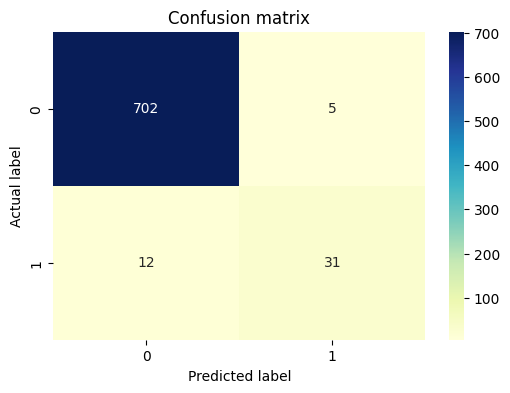

LogisticRegression(random_state=42)

In [28]:
train_and_evaluate_model(LogisticRegression(random_state=42), X_train_scaled, y_train, X_test_scaled, y_test)


Accuracy: 0.9986666666666667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       1.00      0.98      0.99        43

    accuracy                           1.00       750
   macro avg       1.00      0.99      0.99       750
weighted avg       1.00      1.00      1.00       750



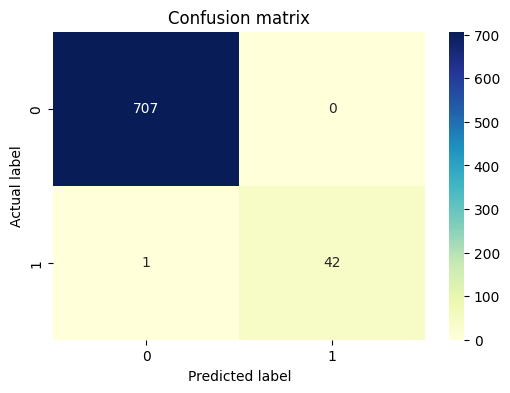

DecisionTreeClassifier(random_state=42)

In [29]:
train_and_evaluate_model(DecisionTreeClassifier(random_state=42), X_train_scaled, y_train, X_test_scaled, y_test)


Accuracy: 0.9986666666666667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       1.00      0.98      0.99        43

    accuracy                           1.00       750
   macro avg       1.00      0.99      0.99       750
weighted avg       1.00      1.00      1.00       750



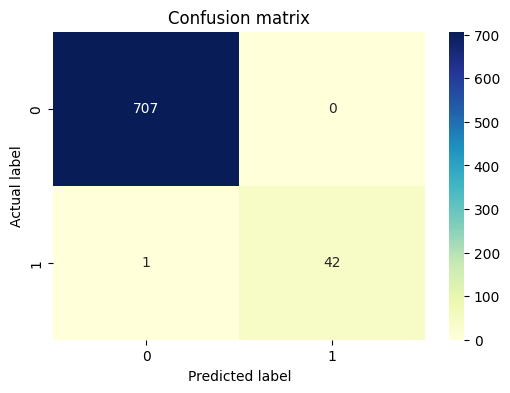

RandomForestClassifier(random_state=42)

In [30]:
train_and_evaluate_model(RandomForestClassifier(random_state=42), X_train_scaled, y_train, X_test_scaled, y_test)

## Model Evaluation and Training

In [31]:
def evaluate_models(models, param_grids, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=models, param_grid=param_grids, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)


    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_model.predict(X_test)
    # Best parameters
    best_parameters = grid_search.best_params_
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f'\nAccuracy: {accuracy}')
    print(f'Classification Report:\n{report}')
    print("Best Parameters:", best_parameters)



    # Evaluation
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


    return best_model


Accuracy: 0.984
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       707
           1       0.86      0.86      0.86        43

    accuracy                           0.98       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.98      0.98      0.98       750

Best Parameters: {'C': 10, 'solver': 'liblinear'}


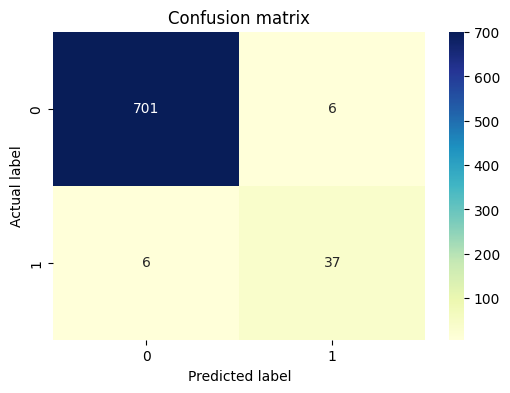

In [32]:
Logistic_regression = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

lr= evaluate_models(LogisticRegression(random_state=42), Logistic_regression, X_train_scaled, y_train, X_test_scaled, y_test)


Accuracy: 0.9986666666666667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       1.00      0.98      0.99        43

    accuracy                           1.00       750
   macro avg       1.00      0.99      0.99       750
weighted avg       1.00      1.00      1.00       750

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


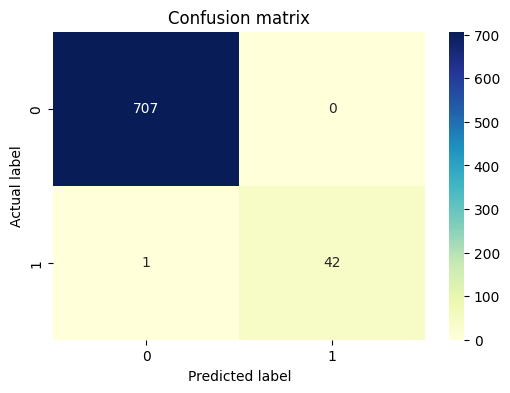

In [33]:
Decision_Tree={
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 2, 4],
}

dt = evaluate_models(DecisionTreeClassifier(random_state=42), Decision_Tree, X_train_scaled, y_train, X_test_scaled, y_test)

In [34]:
Random_Forest= {
        'n_estimators': [50,100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 2, 4],
},

rf = evaluate_models(RandomForestClassifier(random_state=42), Random_Forest, X_train, y_train, X_test, y_test)

KeyboardInterrupt: 

In [ ]:
import pickle

pickle.dump(rf, open('/content/drive/MyDrive/ML_project/models/randomforest.pkl', 'wb'))
pickle.dump(dt, open('/content/drive/MyDrive/ML_project/models/decisiontree.pkl', 'wb'))
pickle.dump(lr, open('/content/drive/MyDrive/ML_project/models/logisticregressionclassifier.pkl', 'wb'))